In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Embedding, Dropout, Flatten, UpSampling1D, UpSampling2D
from keras.layers.convolutional import Conv1D, Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling1D, AveragePooling1D, MaxPooling2D, AveragePooling2D
import keras.backend as K
import keras

from keras.layers import BatchNormalization, Activation
from keras.layers import Input
from keras.regularizers import l2
from keras.losses import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


In [2]:
kernel_size, filters = 3, 16
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

In [3]:
def custom_mse_mae(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)+mean_absolute_error(y_true, y_pred)

In [4]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=False):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv1D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=4):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32,  16
    stage 0: 32,  64
    stage 1: 16, 128
    stage 2:  8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv1D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=True)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=True)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=True)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling1D(pool_size=3)(x)
    y = Flatten()(x)
#    y = Dense(num_classes*32,
#                      activation='relu',
#                      kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
#    y = Dense(num_classes*16,
#                      activation='relu',
#                      kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
#    y = Dense(num_classes*8,
#                      activation='relu',
#                      kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
#      
    outputs = Dense(num_classes,
                    activation='linear',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [19]:
model = resnet_v2(input_shape=(17*2,41), depth=20, num_classes=4)

In [22]:
model.compile(optimizer=adam, loss=custom_mse_mae, metrics=["mean_absolute_error", "mean_squared_error"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34, 41)       0                                            
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 34, 16)       1984        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 34, 16)       64          conv1d_23[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 34, 16)       0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
conv1d_24 

In [9]:
outputs = np.genfromtxt("../data/distanced/ANGLES/outputs.txt")
outputs[np.isnan(outputs)] = 0.0
# Idea convert to sin/cos to remove angle periodicity
outputs.shape

(43001, 2)

In [10]:
out = []
out.append(np.sin(outputs[:,0]))
out.append(np.cos(outputs[:,0]))
out.append(np.sin(outputs[:,1]))
out.append(np.cos(outputs[:,1]))
out = np.array(out).T
print(out.shape)

(43001, 4)


In [11]:
def get_ins(path = "../data/distanced/ANGLES/input_aa.txt", pssm=None):
    # handle both files
    if pssm: path = "../data/distanced/ANGLES/input_pssm.txt"
    # Opn file and read text
    with open(path, "r") as f:
        lines = f.read().split('\n')
    # Extract numeric data from text
    pre_ins = []
    for i,line in enumerate(lines):
        # Read each protein separately
        if line == "NEW":
            prot = []
            raw = lines[i+1:i+(17*2+1)]
            # Read each line as a vector + ensemble one-hot vectors matrix
            for r in raw:
                prot.append(np.array([float(x) for x in r.split(" ") if x != ""]))
            # Add prot to dataset
            pre_ins.append(np.array(prot))  
    
    return np.array(pre_ins)

In [12]:
aas = get_ins()
pssms = get_ins(pssm=True)
# Check shapes match
print(aas.shape, pssms.shape)
# inputs = np.concatenate((aas[:, :, :20], pssms[:, :, :20]), axis=2)
inputs = np.concatenate((aas, pssms[:, :, :20]), axis=2)
# inputs = np.concatenate((aas.reshape((*aas.shape,1)), pssms.reshape((*pssms.shape,1))), axis=3)
inputs.shape

(43001, 34, 21) (43001, 34, 21)


(43001, 34, 41)

In [15]:
# print(np.sin(-1.61735004), np.cos(-1.61735004), np.arccos(1.61))
import matplotlib.pyplot as plt

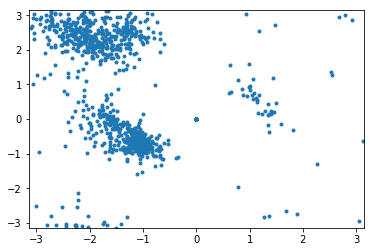

In [16]:
plt.scatter(outputs[:1000,0], outputs[:1000,1], marker=".")
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()

In [17]:
# Preprocess outputs (mean/std)
# mean = np.mean(inputs,axis=(0,1,2))
# std = np.std(inputs,axis=(0,1,2))
# print("Mean: ", mean)
# print("Std: ", std)
# pre_inputs = (inputs-mean)/(std+1e-7)

In [23]:
# Test 1 with 34*41 columns (pre-act structure)
his = model.fit(inputs, out, epochs=5, batch_size=16, verbose=1, shuffle=True, validation_split=0.1)

Train on 38700 samples, validate on 4301 samples
Epoch 1/5
38700/38700 [==============================] - 73s 2ms/step - loss: 1.0670 - mean_absolute_error: 0.4539 - mean_squared_error: 0.3492 - val_loss: 0.9222 - val_mean_absolute_error: 0.4465 - val_mean_squared_error: 0.3240
Epoch 2/5
38700/38700 [==============================] - 67s 2ms/step - loss: 0.8250 - mean_absolute_error: 0.4099 - mean_squared_error: 0.2991 - val_loss: 0.8179 - val_mean_absolute_error: 0.4155 - val_mean_squared_error: 0.3103
Epoch 3/5
38700/38700 [==============================] - 67s 2ms/step - loss: 0.7507 - mean_absolute_error: 0.3908 - mean_squared_error: 0.2800 - val_loss: 0.7755 - val_mean_absolute_error: 0.4069 - val_mean_squared_error: 0.2987
Epoch 4/5
38700/38700 [==============================] - 67s 2ms/step - loss: 0.7155 - mean_absolute_error: 0.3805 - mean_squared_error: 0.2708 - val_loss: 0.7692 - val_mean_absolute_error: 0.4134 - val_mean_squared_error: 0.2966
Epoch 5/5
38700/38700 [========

In [26]:
# Test 1 with 34*41 columns (van der waals radius)
his = model.fit(inputs, out, epochs=5, batch_size=16, verbose=1, shuffle=True, validation_split=0.1)

Train on 38700 samples, validate on 4301 samples
Epoch 1/5
38700/38700 [==============================] - 73s 2ms/step - loss: 1.0124 - mean_absolute_error: 0.4494 - mean_squared_error: 0.3435 - val_loss: 1.0109 - val_mean_absolute_error: 0.4762 - val_mean_squared_error: 0.4162
Epoch 2/5
38700/38700 [==============================] - 67s 2ms/step - loss: 0.7932 - mean_absolute_error: 0.4056 - mean_squared_error: 0.2941 - val_loss: 0.7772 - val_mean_absolute_error: 0.4095 - val_mean_squared_error: 0.2919
Epoch 3/5
38700/38700 [==============================] - 67s 2ms/step - loss: 0.7324 - mean_absolute_error: 0.3879 - mean_squared_error: 0.2769 - val_loss: 0.7751 - val_mean_absolute_error: 0.4078 - val_mean_squared_error: 0.3063
Epoch 4/5
38700/38700 [==============================] - 67s 2ms/step - loss: 0.7024 - mean_absolute_error: 0.3780 - mean_squared_error: 0.2676 - val_loss: 0.7855 - val_mean_absolute_error: 0.4106 - val_mean_squared_error: 0.3215
Epoch 5/5
38700/38700 [========

In [23]:
# Test 1 with 34*40 columns
his = model.fit(inputs, out, epochs=5, batch_size=16, verbose=1, shuffle=True, validation_split=0.1)

Train on 38700 samples, validate on 4301 samples
Epoch 1/5
38700/38700 [==============================] - 74s 2ms/step - loss: 1.0404 - mean_absolute_error: 0.4501 - mean_squared_error: 0.3464 - val_loss: 0.9905 - val_mean_absolute_error: 0.4696 - val_mean_squared_error: 0.3864
Epoch 2/5
38700/38700 [==============================] - 69s 2ms/step - loss: 0.8102 - mean_absolute_error: 0.4081 - mean_squared_error: 0.2982 - val_loss: 0.8063 - val_mean_absolute_error: 0.4239 - val_mean_squared_error: 0.2992
Epoch 3/5
38700/38700 [==============================] - 69s 2ms/step - loss: 0.7433 - mean_absolute_error: 0.3907 - mean_squared_error: 0.2798 - val_loss: 0.7620 - val_mean_absolute_error: 0.4052 - val_mean_squared_error: 0.2924
Epoch 4/5
38700/38700 [==============================] - 68s 2ms/step - loss: 0.7125 - mean_absolute_error: 0.3811 - mean_squared_error: 0.2721 - val_loss: 0.7565 - val_mean_absolute_error: 0.4082 - val_mean_squared_error: 0.2938
Epoch 5/5
38700/38700 [========

In [24]:
n = 10000
preds = model.predict(inputs)

In [25]:
# Get angle values from sin and cos
refactor = []
for pred in preds:
    angles = []
    phi_sin, phi_cos, psi_sin, psi_cos = pred[0], pred[1], pred[2], pred[3]
    # PHI - First and fourth quadrant
    if (phi_sin>=0 and phi_cos>=0) or (phi_cos>=0 and phi_sin<=0):
        angles.append(np.arctan(phi_sin/phi_cos))
    # 2nd and 3rd quadrant
    else:
        angles.append(np.pi + np.arctan(phi_sin/phi_cos))
        
    # PSI - First and fourth quadrant
    if (psi_sin>=0 and psi_cos>=0) or (psi_cos>=0 and psi_sin<=0):
        angles.append(np.arctan(psi_sin/psi_cos))
    # 2nd and 3rd quadrant
    else:
        angles.append(np.pi + np.arctan(psi_sin/psi_cos))
    
    refactor.append(angles)
    
refactor = np.array(refactor)
print(refactor.shape)

(43001, 2)


In [26]:
print("PREDS: ", preds[40:50])
print("OUT: ", out[40:50])
print("----------------------------------------")
print("REFACTOR: ", refactor[:10])
print("OUTPUTS: ", outputs[:10])

PREDS:  [[-0.88067687  0.12265779  0.03935923  0.22878006]
 [-0.92074037  0.27919453 -0.09113257  0.45687264]
 [-0.8112581   0.13371193 -0.04036168  0.33211333]
 [-0.93063664  0.1092518   0.1932747   0.1556783 ]
 [-0.78976667 -0.05227512  0.30784813 -0.10911738]
 [-0.83434737 -0.04871911  0.20036834 -0.16656926]
 [-0.86915624  0.27707267 -0.22748195  0.6596681 ]
 [-0.84250736  0.10340905  0.1329841   0.32837895]
 [-0.83278775 -0.07911474  0.35720548 -0.09560899]
 [-0.83226275 -0.2811734   0.5461851  -0.463168  ]]
OUT:  [[-0.89435741  0.44735313 -0.57443578  0.81854966]
 [-0.87376279  0.48635232 -0.622015    0.78300533]
 [-0.90627582  0.42268681 -0.77934285  0.62659774]
 [-0.95801371  0.2867224  -0.72077014  0.69317415]
 [-0.93497954  0.35470165 -0.43613418  0.89988165]
 [-0.960727    0.27749528 -0.2523779   0.96762875]
 [-0.96919641 -0.24628908  0.87398424 -0.48595426]
 [-0.99699843 -0.07742175 -0.48280369  0.87572861]
 [-0.85155377 -0.52426727  0.08061925  0.99674497]
 [-0.77707837 -0

In [27]:
refactor[refactor>np.pi] = np.pi
refactor[refactor<-np.pi] = -np.pi

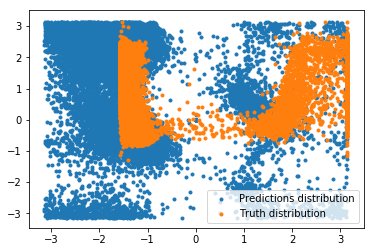

In [31]:
plt.scatter(outputs[:,0], outputs[:,1], marker=".")
plt.scatter(refactor[:,0], refactor[:,1], marker=".")
plt.legend(["Predictions distribution", "Truth distribution"], loc="lower right")
# plt.xlim(-np.pi, np.pi)
# plt.ylim(-np.pi, np.pi)
plt.show()

In [29]:
# Correlattion coefficients are: - model.save("resnet_20_no_norm_1d_5epochs_preact_vdw_radius.h5")
# Calculate Perason coefficient btwn cosines of both angles (true values and predicted ones)
cos_phi = np.corrcoef(preds[:, 1], out[:, 1])
cos_psi = np.corrcoef(preds[:, 3], out[:, 3])

cos_phi = np.corrcoef(np.cos(refactor[:,0]), np.cos(outputs[:,0]))
cos_phi = np.corrcoef(np.cos(refactor[:,1]), np.cos(outputs[:,1]))

print("Correlation coefficients - SOTA is Phi: 0.65 | Psi: 0.7")
print("Cos Phi: ", cos_phi[0,1])
print("Cos Psi: ", cos_psi[0,1])

Correlation coefficients - SOTA is Phi: 0.65 | Psi: 0.7
Cos Phi:  0.5434985429784274
Cos Psi:  0.5770063406475973


In [30]:
model.save("resnet_20_no_norm_1d_5epochs_preact_vdw_radius.h5")

In [ ]:
# Done!